In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC

sns.set()

In [67]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 100)
    y = np.linspace(ylim[0], ylim[1], 100)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(
        X,
        Y,
        P,
        colors="k",
        levels=[-1, 0, 1],
        alpha=0.5,
        linestyles=["dashed", "dashdot", "dotted"],
    )

    # plot support vectors
    if plot_support:
        ax.scatter(
            model.support_vectors_[:, 0],
            model.support_vectors_[:, 1],
            s=300,
            linewidth=1,
            facecolors="none",
        )
    # ax.set_xlim(xlim)
    # ax.set_ylim(ylim)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

In [81]:
# Helper function to calculate hinge loss
def compute_hinge_loss(model, X, y):
    decision_values = model.decision_function(X)
    # For binary classification, hinge loss is max(0, 1 - y * f(x))
    y_svm = 2 * y - 1  # Transforms 0->-1 and 1->+1
    losses = np.maximum(0, 1 - y_svm * decision_values)
    return np.mean(losses)

In [79]:
def svm_loss(X, y, W, b, reg_lambda=0.01):
    """
    Calculate the training loss for an SVM model with binary labels (0 and 1).

    Parameters:
    -----------
    X : numpy.ndarray
        Input features, shape (n_samples, n_features)
    y : numpy.ndarray
        Binary labels (0 or 1), shape (n_samples,)
    W : numpy.ndarray
        Weight parameters, shape (n_features,)
    b : float
        Bias parameter
    reg_lambda : float, optional
        Regularization parameter (default=0.01)

    Returns:
    --------
    float
        The total loss (hinge loss + regularization)
    """
    # Convert 0/1 labels to -1/+1 for SVM
    y_svm = 2 * y - 1  # Transforms 0->-1 and 1->+1

    # Calculate scores: w·x + b
    scores = np.dot(X, W) + b

    # Calculate margins: y * (w·x + b)
    margins = y_svm * scores

    # Calculate hinge loss: max(0, 1 - margin)
    hinge_losses = np.maximum(0, 1 - margins)

    # Mean hinge loss across all samples
    data_loss = np.mean(hinge_losses)

    # L2 regularization term
    # reg_loss = reg_lambda * np.sum(W * W)

    # # Total loss
    # total_loss = data_loss + reg_loss

    return data_loss

In [70]:
data = pd.read_csv("nonlinear_svm_data.csv", header=0, sep=",")
X = data.iloc[:, :-1].values  # All rows, all columns except the last
y = data.iloc[:, -1].values  # All rows, only the last column


In [82]:
print("\nQuestion 1: Linear SVM with different C values")
c_values = [1, 100, 1000]
linear_results = []

for c in c_values:
    # Train Linear SVM
    print(f"\nTraining Linear SVM with C={c}...")
    linear_svm = SVC(kernel="linear", C=c, random_state=42)
    linear_svm.fit(X, y)
    # Get weights and bias
    weights = linear_svm.coef_[
        0
    ]  # For binary classification, it's the first (and only) element
    bias = linear_svm.intercept_[0]

    print("Weights:", weights)
    print("Bias:", bias)

    # Calculate training loss
    train_loss = compute_hinge_loss(linear_svm, X, y)

    new_losss = svm_loss(X, y, weights, bias)

    # Store results
    linear_results.append(
        {
            "C": c,
            "Training Loss": train_loss,
            "New Loss": new_losss,
            "Support Vectors": linear_svm.n_support_.sum(),
            "Training Accuracy": linear_svm.score(X, y),
        }
    )

    print(f"Training Loss: {train_loss:.4f}")
    print(f"New Loss: {new_losss:.4f}")
    print(f"Number of Support Vectors: {linear_svm.n_support_.sum()}")
    print(f"Training Accuracy: {linear_svm.score(X, y):.4f}")

    # Plot decision boundary
    # plt_obj = plot_decision_boundary(
    #     linear_svm, X_train, y_train, f"Linear SVM (C={c}), Loss={train_loss:.4f}"
    # )
    # plt_obj.savefig(f"linear_svm_c{c}.png")
    # plt.close()

# Display Linear SVM results
print("\nLinear SVM Results Summary:")
linear_df = pd.DataFrame(linear_results)
print(linear_df)



Question 1: Linear SVM with different C values

Training Linear SVM with C=1...
Weights: [-0.00011281  0.00045126]
Bias: -1.0001015308367223
Training Loss: 0.8001
New Loss: 0.8001
Number of Support Vectors: 18
Training Accuracy: 0.6000

Training Linear SVM with C=100...
Weights: [ 1.04005739e-04 -2.60984042e-05]
Bias: -1.0
Training Loss: 0.8000
New Loss: 0.8000
Number of Support Vectors: 18
Training Accuracy: 0.6000

Training Linear SVM with C=1000...
Weights: [4.87886496e-08 6.17966089e-06]
Bias: -1.000000007794472
Training Loss: 0.8000
New Loss: 0.8000
Number of Support Vectors: 20
Training Accuracy: 0.6000

Linear SVM Results Summary:
      C  Training Loss  New Loss  Support Vectors  Training Accuracy
0     1       0.800063  0.800063               18                0.6
1   100       0.800012  0.800012               18                0.6
2  1000       0.800001  0.800001               20                0.6


In [83]:
# Question 2: SVM with Gaussian kernel
print("\nQuestion 2: SVM with Gaussian Kernel")
a_values = [0.1, 1, 10]
rbf_results = []

for a in a_values:
    # Convert 'a' to gamma: gamma = 1/(2a²)
    gamma = 1 / (2 * (a**2))

    # Train RBF SVM
    print(f"\nTraining Gaussian Kernel SVM with a={a}, gamma={gamma:.6f}...")
    rbf_svm = SVC(kernel="rbf", C=1, gamma=gamma, random_state=42)
    rbf_svm.fit(X, y)

    # Calculate training loss
    train_loss = compute_hinge_loss(rbf_svm, X, y)

    # Store results
    rbf_results.append(
        {
            "a": a,
            "gamma": gamma,
            "Training Loss": train_loss,
            "Support Vectors": rbf_svm.n_support_.sum(),
            "Training Accuracy": rbf_svm.score(X, y),
        }
    )

    print(f"Training Loss: {train_loss:.4f}")
    print(f"Number of Support Vectors: {rbf_svm.n_support_.sum()}")
    print(f"Training Accuracy: {rbf_svm.score(X, y):.4f}")

    # Plot decision boundary
    # plt_obj = plot_decision_boundary(
    #     rbf_svm,
    #     X_train,
    #     y_train,
    #     f"Gaussian Kernel SVM (a={a}, γ={gamma:.6f}), Loss={train_loss:.4f}",
    # )
    # plt_obj.savefig(f"gaussian_svm_a{a}.png")
    # plt.close()

# Display Gaussian SVM results
print("\nGaussian Kernel SVM Results Summary:")
rbf_df = pd.DataFrame(rbf_results)
print(rbf_df)


Question 2: SVM with Gaussian Kernel

Training Gaussian Kernel SVM with a=0.1, gamma=50.000000...
Training Loss: 0.0628
Number of Support Vectors: 20
Training Accuracy: 1.0000

Training Gaussian Kernel SVM with a=1, gamma=0.500000...
Training Loss: 0.7263
Number of Support Vectors: 18
Training Accuracy: 0.6000

Training Gaussian Kernel SVM with a=10, gamma=0.005000...
Training Loss: 0.8000
Number of Support Vectors: 17
Training Accuracy: 0.6000

Gaussian Kernel SVM Results Summary:
      a   gamma  Training Loss  Support Vectors  Training Accuracy
0   0.1  50.000       0.062784               20                1.0
1   1.0   0.500       0.726271               18                0.6
2  10.0   0.005       0.800040               17                0.6


In [ ]:
model = SVC(kernel="linear", C=10)
model.fit(X, y)

SVC(C=10, kernel='linear')

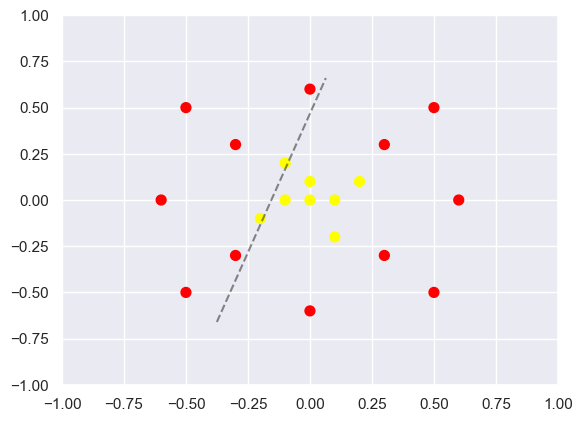

In [68]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="autumn")
plot_svc_decision_function(model);

In [55]:
a_values = [0.1, 1, 10]
gamma = 1 / (2 * (1**2))

In [56]:
rbf_svm = SVC(kernel="rbf", C=1, gamma=gamma, random_state=42)
rbf_svm.fit(X, y)


SVC(C=1, gamma=0.5, random_state=42)

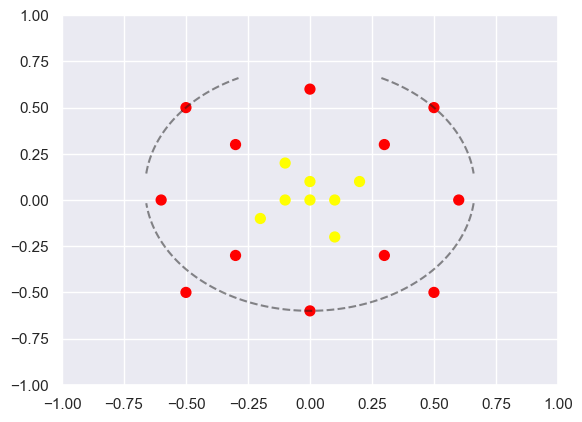

In [69]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="autumn")
plot_svc_decision_function(rbf_svm)
plt.scatter(
    rbf_svm.support_vectors_[:, 0],
    rbf_svm.support_vectors_[:, 1],
    s=300,
    lw=1,
    facecolors="none",
);